In [57]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from typing import Dict, List
import numpy as np

In [58]:
def get_material_categories(root_dir):
    categories = []
    for root, dirs, files in os.walk(root_dir):
        if 'filter.json' in files:
            try:
                with open(os.path.join(root, 'filter.json'), 'r') as f:
                    data = json.load(f)
                    if 'material_category' in data:
                        if isinstance(data['material_category'], str):
                            categories.append(data['material_category'])
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Error reading {os.path.join(root, 'filter.json')}: {e}")
    return categories

def plot_categories(categories):
    # Set the style
    
    # Count occurrences of each category
    category_counts = Counter(categories)
    
    # Get top 10 categories and calculate others
    top_categories = category_counts.most_common(10)
    
    # Calculate total "Others" count including "other" category
    others_count = sum(count for cat, count in category_counts.most_common()[10:])
    if 'Other' in category_counts:
        others_count += category_counts['Other']
        # Remove "other" from top categories if present
        top_categories = [(cat, count) for cat, count in top_categories if cat != 'Other']
    
    # Extract categories and counts
    categories, counts = zip(*top_categories)
    categories = list(categories)
    counts = list(counts)
    
    # Add the combined "Others" category
    categories.append('Others')
    counts.append(others_count)
    
    # Calculate total for percentage
    total = sum(counts)
    
    # Create color palette
    colors = sns.color_palette('husl', n_colors=len(categories))
    
    # Create the pie chart
    plt.figure(figsize=(12, 8))
    
    # Create pie chart with a slight explode effect for the top 3 categories
    explode = [0.05 if i < 3 else 0 for i in range(len(categories))]
    
    wedges, texts, autotexts = plt.pie(counts, 
                                      explode=explode,
                                      labels=categories, 
                                      colors=colors,
                                      autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*total):,})',
                                      pctdistance=0.85,
                                      wedgeprops={'edgecolor': 'white', 
                                                 'linewidth': 2})
    
    # Enhance the appearance of labels and percentages
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=10)
    
    # Add a title with custom styling
    plt.title('Distribution of Material Categories\nTop 10 Most Common Categories', 
              pad=20, 
              size=14, 
              weight='bold')
    
    # Add a subtle circle at the center
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.axis('equal')
    plt.tight_layout()
    
    # Save with high DPI for better quality
    # plt.savefig('material_categories_pie.png', 
    #             dpi=300, 
    #             bbox_inches='tight',
    #             facecolor='white',
    #             edgecolor='none')
    plt.show()

1467


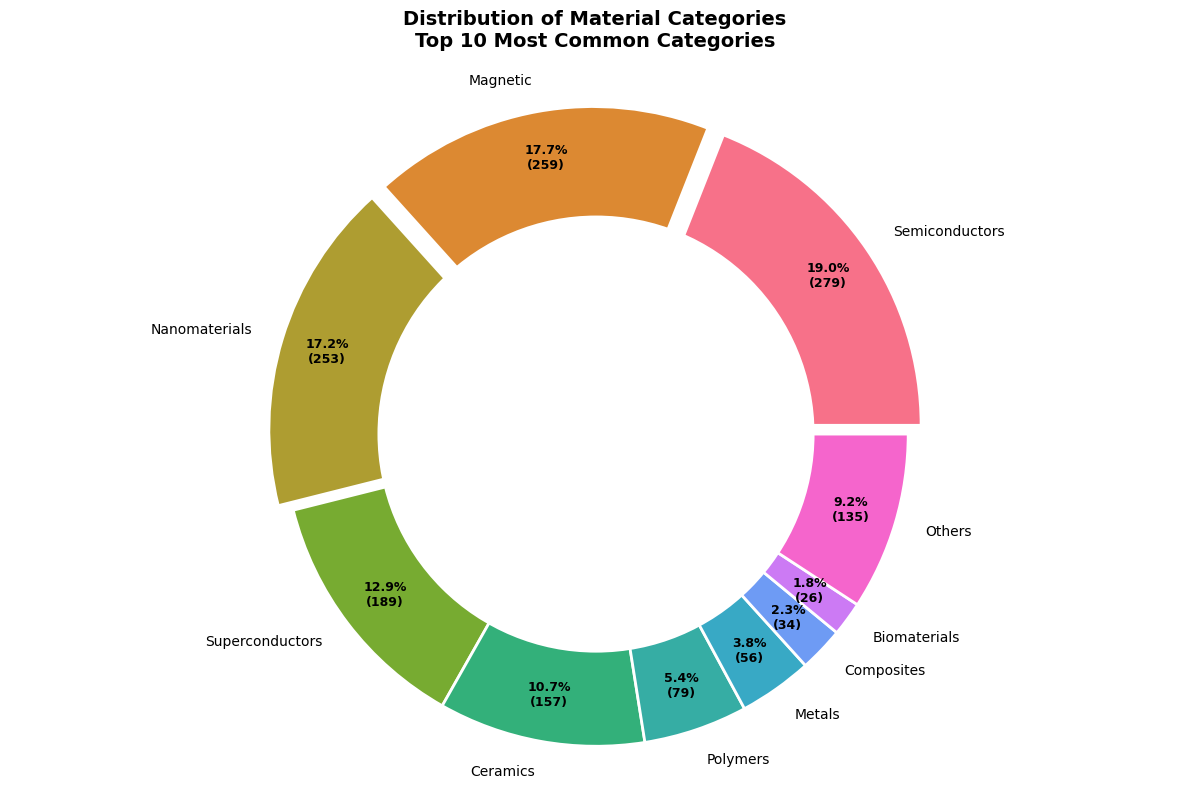

In [59]:
root_dir = "data/filtered/cond-mat/2025"
categories = get_material_categories(root_dir)
print(len(categories))
plot_categories(categories) 

In [60]:
def count_synthesis_steps(root_dir: str) -> Dict[str, List[int]]:
    """Count the number of synthesis steps for each material category."""
    category_steps = defaultdict(list)
    
    for root, _, files in os.walk(root_dir):
        if 'synthesis_step_by_step.json' in files:
            try:
                with open(os.path.join(root, 'synthesis_step_by_step.json'), 'r') as f:
                    data = json.load(f)
                    # Get the number of steps in the procedure
                    procedure = data.get('procedure', [])
                    if not procedure:
                        continue
                        
                    num_steps = len(procedure)
                    
                    # Get the material category from filter.json
                    filter_path = os.path.join(root, 'filter.json')
                    if os.path.exists(filter_path):
                        with open(filter_path, 'r') as filter_f:
                            filter_data = json.load(filter_f)
                            category = filter_data.get('material_category')
                            if isinstance(filter_data['material_category'], str):
                                if category and num_steps > 0:
                                    category_steps[category].append(num_steps)
            except (json.JSONDecodeError, KeyError):
                continue
    
    return category_steps

def plot_synthesis_steps(category_steps: Dict[str, List[int]], top_n: int = 12):
    """Plot the average number of synthesis steps for the top N material categories."""
    if not category_steps:
        return
        
    # Calculate average steps and standard error per category
    avg_steps = {}
    std_err = {}
    for cat, steps in category_steps.items():
        avg_steps[cat] = np.mean(steps)
        std_err[cat] = np.std(steps) / np.sqrt(len(steps))
    
    # Sort categories by number of samples
    categories_by_samples = sorted(category_steps.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]
    categories = [cat for cat, _ in categories_by_samples]
    
    # Prepare data for plotting
    avg_steps_values = [avg_steps[cat] for cat in categories]
    std_err_values = [std_err[cat] for cat in categories]
    num_recipes = [len(category_steps[cat]) for cat in categories]
        
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar plot with error bars
    bars = ax.bar(categories, avg_steps_values, color='skyblue', 
                  yerr=std_err_values, capsize=5, ecolor='black')
    
    # Add number of recipes as text above bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std_err_values[i] + 0.1,
                f'n={num_recipes[i]}',
                ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_xlabel('Material Category', fontsize=12)
    ax.set_ylabel('Average Number of Synthesis Steps', fontsize=12)
    ax.set_title('Average Number of Synthesis Steps by Material Category\n(Top 12 Categories by Number of Samples)', 
                 fontsize=14, pad=20)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('synthesis_steps_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()

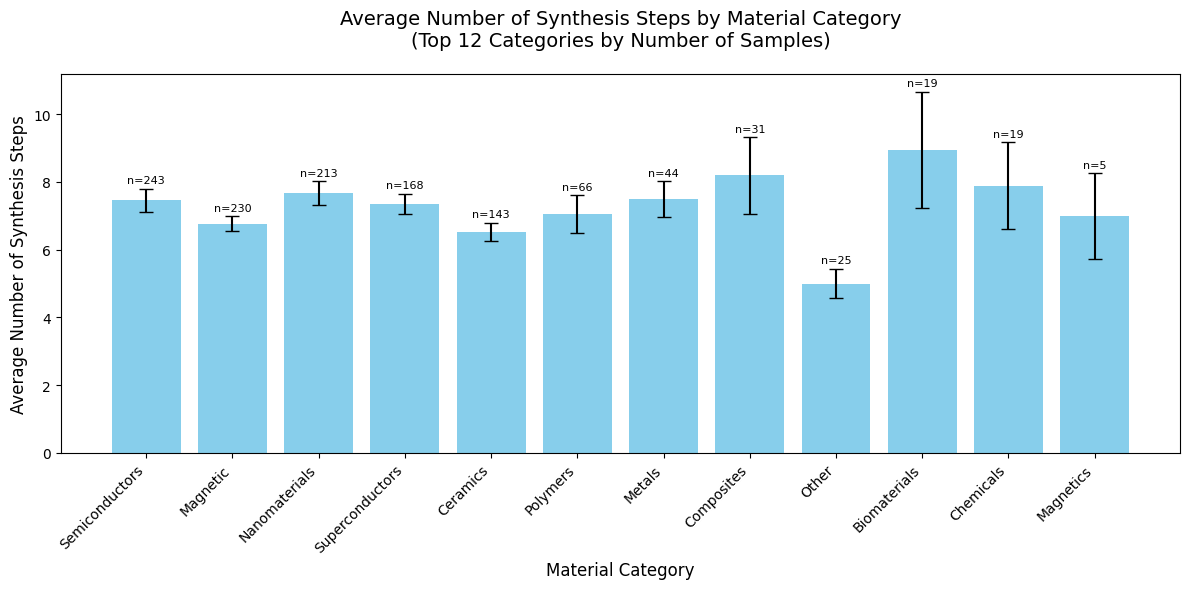

In [61]:
root_dir = "data/filtered/cond-mat/2025"
category_steps = count_synthesis_steps(root_dir)
plot_synthesis_steps(category_steps)

In [63]:
for category, steps in category_steps.items():
    print(category, Counter(steps))

Ceramics Counter({6: 36, 5: 27, 7: 24, 4: 19, 9: 9, 8: 9, 3: 7, 10: 5, 19: 2, 28: 1, 17: 1, 14: 1, 16: 1, 1: 1})
Magnetic Counter({6: 50, 5: 46, 7: 38, 4: 25, 8: 22, 9: 14, 10: 10, 1: 5, 3: 5, 11: 4, 12: 3, 21: 2, 17: 1, 18: 1, 19: 1, 13: 1, 15: 1, 34: 1})
Polymers Counter({6: 18, 5: 12, 7: 9, 8: 6, 1: 3, 9: 3, 11: 2, 4: 2, 14: 2, 3: 2, 2: 2, 10: 2, 27: 1, 29: 1, 12: 1})
Other Counter({4: 7, 5: 5, 7: 4, 1: 3, 8: 2, 6: 2, 3: 1, 10: 1})
Semiconductors Counter({6: 54, 5: 38, 7: 35, 4: 30, 8: 27, 10: 9, 9: 8, 1: 6, 3: 4, 12: 4, 11: 4, 13: 3, 2: 3, 18: 3, 20: 3, 22: 2, 24: 1, 14: 1, 23: 1, 16: 1, 59: 1, 17: 1, 15: 1, 19: 1, 30: 1, 25: 1})
Metamaterials Counter({8: 1})
Nanomaterials Counter({6: 55, 5: 30, 7: 25, 8: 24, 9: 18, 4: 14, 3: 8, 10: 8, 12: 4, 2: 4, 1: 3, 11: 3, 27: 2, 21: 2, 17: 2, 14: 2, 15: 1, 30: 1, 18: 1, 20: 1, 32: 1, 22: 1, 13: 1, 28: 1, 39: 1})
Biomaterials Counter({6: 8, 7: 3, 4: 1, 9: 1, 3: 1, 8: 1, 28: 1, 5: 1, 32: 1, 12: 1})
Metals Counter({7: 8, 5: 7, 6: 7, 8: 5, 4: 5, 